<a href="https://colab.research.google.com/github/Nishlesh/Monte-carlo/blob/main/Naked_call.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   Strike  Max_Profit  Max_Loss  Reward_Risk_Ratio  Probability_of_Profit
0   24300         inf      7725                inf               0.606582
1   24250         inf      8536                inf               0.639638
2   24350         inf      7025                inf               0.571258
3   24200         inf      9325                inf               0.673363
4   24400         inf      6250                inf               0.536833
5   24150         inf     10035                inf               0.711410
6   24450         inf      5815                inf               0.500581
7   24100         inf     10995                inf               0.739412
8   24500         inf      5125                inf               0.465686
9   24050         inf     11776                inf               0.777486
Top Long Call Strategy:
Strike                   2.405000e+04
Max_Profit                        inf
Max_Loss                 1.177600e+04
Reward_Risk_Ratio                 inf
Probabilit

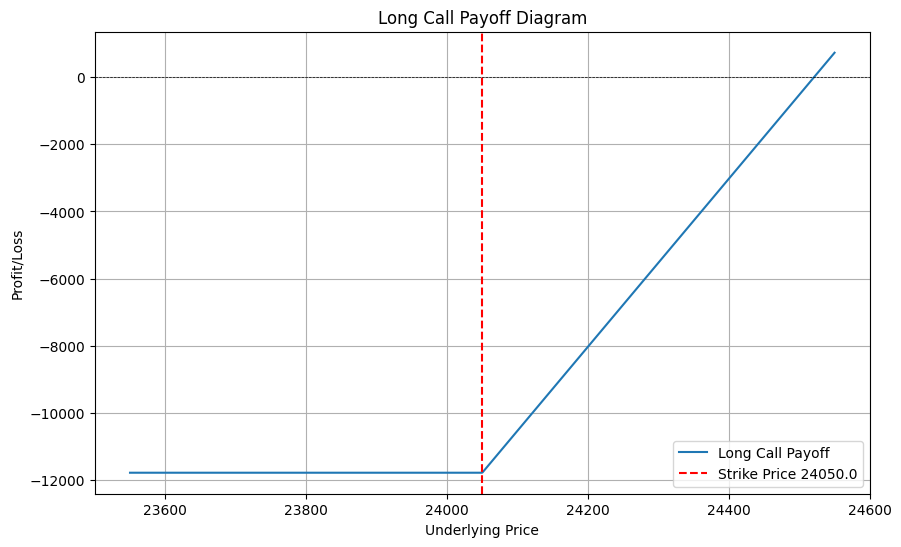

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import itertools

# Load the data
file_path = '/content/option-chain-ED-NIFTY-25-Jul-2024.csv'
df = pd.read_csv(file_path)

# Extract relevant columns
df = df[['STRIKE', 'IV_CALLS', 'LTP_CALLS']]
df['STRIKE'] = df['STRIKE'].replace(',', '').astype(float)
df['IV_CALLS'] = df['IV_CALLS'].replace('-', np.nan).astype(float)
df['LTP_CALLS'] = df['LTP_CALLS'].str.replace(',', '').astype(float)
df['IV_CALLS'] = df['IV_CALLS']/100
# Define constants
S0 = 24324  # Current price of NIFTY
T = 20 / 365  # Time to expiry
r = 0.10  # Risk-free rate
lot_size = 25  # Lot size

# Generate nearest 10 strike prices to the ATM
ATM_strike = df.iloc[(df['STRIKE'] - S0).abs().argsort()[:1]]['STRIKE'].values[0]
strike_prices = df['STRIKE'].unique()
nearest_strikes = sorted(strike_prices, key=lambda x: abs(x - ATM_strike))[:10]

# Filter relevant rows for nearest strikes and use LTP_CALLS directly
df_nearest = df[df['STRIKE'].isin(nearest_strikes)].copy()
df_nearest['Call_Price'] = df_nearest['LTP_CALLS']

# Generate all possible long call strategies
long_calls = nearest_strikes
strategies = []

for K in long_calls:
    call_price = df_nearest[df_nearest['STRIKE'] == K]['Call_Price'].values[0]

    # Calculate max profit, max loss, reward/risk ratio, and probability of profit
    max_profit = np.inf
    max_loss = call_price
    reward_risk_ratio = np.inf

    # Assuming probability of profit based on ATM strike
    prob_profit = norm.cdf((np.log(S0 / K) + (r - 0.5 * df_nearest[df_nearest['STRIKE'] == K]['IV_CALLS'].values[0] ** 2) * T) / (df_nearest[df_nearest['STRIKE'] == K]['IV_CALLS'].values[0] * np.sqrt(T)))

    strategies.append({
        'Strike': int(K),
        'Max_Profit': max_profit,
        'Max_Loss': int(max_loss * lot_size),
        'Reward_Risk_Ratio': reward_risk_ratio,
        'Probability_of_Profit': prob_profit
    })

# Create DataFrame from strategies list
strategies_df = pd.DataFrame(strategies)
print(strategies_df)

# TOPSIS method
def topsis(df, weights):
    df = df.copy()
    # Normalize the decision matrix
    norm_matrix = df / np.sqrt((df**2).sum())

    # Weighted normalized decision matrix
    weighted_matrix = norm_matrix * weights

    # Identify ideal and negative-ideal solutions
    ideal_solution = weighted_matrix.max()
    negative_ideal_solution = weighted_matrix.min()

    # Calculate the distance to ideal and negative-ideal solutions
    dist_to_ideal = np.sqrt(((weighted_matrix - ideal_solution) ** 2).sum(axis=1))
    dist_to_neg_ideal = np.sqrt(((weighted_matrix - negative_ideal_solution) ** 2).sum(axis=1))

    # Calculate the relative closeness to the ideal solution
    topsis_score = dist_to_neg_ideal / (dist_to_ideal + dist_to_neg_ideal)

    return topsis_score

# Define weights for each parameter
weights = pd.Series({
    'Probability_of_Profit': 0.5,
    'Max_Loss': 0.3,
    'Max_Profit': 0.2
})

# Rank strategies using TOPSIS
strategies_df['TOPSIS_Score'] = topsis(strategies_df[['Probability_of_Profit', 'Max_Loss', 'Max_Profit']], weights)
strategies_df['Rank'] = strategies_df['TOPSIS_Score'].rank(ascending=False)

# Display the top strategy
top_strategy = strategies_df.sort_values(by='Rank').iloc[0]
top_strategy['Strike'] = int(top_strategy['Strike'])
top_strategy['Max_Loss'] = int(top_strategy['Max_Loss'])
print(f"Top Long Call Strategy:\n{top_strategy}")

# Plot payoff graph for the top strategy
K = top_strategy['Strike']
call_price = df_nearest[df_nearest['STRIKE'] == K]['Call_Price'].values[0]

# Define the range of underlying prices at expiration
S_range = np.linspace(K - 500, K + 500, 1000)

# Payoff function for the long call strategy
payoff = 25*np.where(
    S_range <= K,
    -call_price,
    S_range - K - call_price
)

# Plotting the payoff graph
plt.figure(figsize=(10, 6))
plt.plot(S_range, payoff, label='Long Call Payoff')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(K, color='r', linestyle='--', label=f'Strike Price {K}')
plt.title('Long Call Payoff Diagram')
plt.xlabel('Underlying Price')
plt.ylabel('Profit/Loss')
plt.legend()
plt.grid(True)
plt.show()
